In [77]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, when, count
from pyspark import SparkConf

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

conf = SparkConf() \
    .setAppName("Projectphase3") \
    .set("spark.ui.port", "4088") \
    .set("spark.network.timeout", "3000s") \
    .set("spark.executor.heartbeatInterval", "300s") \
    .set("spark.driver.maxResultSize", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.cores", "8") \
    .set("spark.driver.memory", "16g") \
    .set("spark.sql.shuffle.partitions", "1000") \
    .set("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .set("spark.sql.files.maxPartitionBytes", "134217728") \
    .set("spark.sql.files.openCostInBytes", "134217728") \
    .set("spark.dynamicAllocation.enabled", "true") \
    .set("spark.dynamicAllocation.minExecutors", "2") \
    .set("spark.dynamicAllocation.maxExecutors", "50") \
    .set("spark.dynamicAllocation.initialExecutors", "5") \
    .set("spark.executor.instances", "50") \
    .set("spark.kryoserializer.buffer.max", "512m") \
    .set("spark.sql.adaptive.enabled", "true") \
    .set("spark.memory.fraction", "0.8") \
    .set("spark.memory.storageFraction", "0.7")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

sc = spark.sparkContext

print(f"Spark session started successfully with app name: {spark.conf.get('spark.app.name')}")

Spark session started successfully with app name: Projectphase3


In [78]:
file_path = "2019.csv" 
df = spark.read.csv(file_path, header=True, inferSchema=True)


df.printSchema()


root
 |-- FL_DATE: date (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- NAS_DELAY: double (nullable = true)
 |-- SECURITY_DELAY: double (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: double (nullable = true)
 |-- _c20: string (nullable = true)



In [79]:
df.show(5)

+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+
|   FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|_c20|
+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+
|2019-01-01|               9E|             3280|   GNV| ATL|     601|      1.0|    22.0|       623|      714|    8.0|     722|     -1.0|    51.0|   300.0|         NULL|         NULL|     NULL|          NULL|               NULL|NULL|
|2019-01-01|               9E|             3281|   MSP| CVG|    1359

In [80]:
print("Columns in the dataset:", df.columns)

Columns in the dataset: ['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', '_c20']


In [81]:
df.select("_c20").distinct().show()

+----+
|_c20|
+----+
|NULL|
+----+



In [82]:
#1 Drop the last column because it is unrelated to out task.
df_cleaned = df.drop("_c20")
print(df_cleaned.columns)
df_cleaned.show(5)

['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2019-01-01|               9E|  

In [83]:
# Checking missing value for carrier flight number
missing_values_check = df_cleaned.filter(df_cleaned["OP_CARRIER_FL_NUM"].isNotNull()).count() == df_cleaned.count()
print(missing_values_check)

if not missing_values_check:
    df_cleaned = df_cleaned.filter(df_cleaned["OP_CARRIER_FL_NUM"].isNotNull())
df_cleaned.show(5)


True
+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2019-01-01|               9E|             3280|   GNV| ATL|     601|      1.0|    22.0|       623|      714|    8.0|     722|     -1.0|    51.0|   300.0|         NULL|         NULL|     NULL|          NULL|               NULL|
|2019-01-01|               9E|             3281|   MSP| CVG|    1359|     -5.0|    

In [84]:
from pyspark.sql.functions import to_timestamp

# 'FL_DATE' to timestamp
df_cleaned = df_cleaned.withColumn("FL_DATE", to_timestamp("FL_DATE", "yyyy-MM-dd HH:mm:ss"))

df_cleaned.printSchema()


root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- NAS_DELAY: double (nullable = true)
 |-- SECURITY_DELAY: double (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: double (nullable = true)



In [85]:
from pyspark.sql.functions import dayofmonth, month, dayofweek, col
from pyspark.sql.functions import floor, col
# 4 Day, Month, and Weekday from 'FL_DATE'
df_cleaned = df_cleaned.withColumn("FL_DAY", dayofmonth("FL_DATE"))
df_cleaned = df_cleaned.withColumn("FL_MONTH", month("FL_DATE"))
df_cleaned = df_cleaned.withColumn("FL_WEEKDAY", dayofweek("FL_DATE"))

#5 hours and minutes from 'DEP_TIME' and 'ARR_TIME'
df_cleaned = df_cleaned.withColumn("DEP_HOUR", floor(df_cleaned["DEP_TIME"] / 100))
df_cleaned = df_cleaned.withColumn("DEP_MINUTE", df_cleaned["DEP_TIME"] % 100)
df_cleaned = df_cleaned.withColumn("ARR_HOUR", floor(df_cleaned["ARR_TIME"] / 100))
df_cleaned = df_cleaned.withColumn("ARR_MINUTE", df_cleaned["ARR_TIME"] % 100)


# 6 total delay
df_cleaned = df_cleaned.withColumn("TOTAL_DELAY", col("DEP_DELAY") + col("ARR_DELAY"))

df_cleaned.show(5)


+-------------------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+------+--------+----------+--------+----------+--------+----------+-----------+
|            FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_TIME|ARR_DELAY|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|FL_DAY|FL_MONTH|FL_WEEKDAY|DEP_HOUR|DEP_MINUTE|ARR_HOUR|ARR_MINUTE|TOTAL_DELAY|
+-------------------+-----------------+-----------------+------+----+--------+---------+--------+----------+---------+-------+--------+---------+--------+--------+-------------+-------------+---------+--------------+-------------------+------+--------+----------+--------+----------+--------+----------+-----------+
|2019-01-01 00:00:00|               9E|             

In [86]:
value_counts = df_cleaned.groupBy("TOTAL_DELAY").count().orderBy("count", ascending=False)
value_counts.show()

+-----------+------+
|TOTAL_DELAY| count|
+-----------+------+
|      -15.0|173668|
|      -16.0|173491|
|      -14.0|173133|
|      -17.0|172261|
|      -13.0|170614|
|      -18.0|168335|
|      -12.0|167595|
|      -19.0|163695|
|      -11.0|163036|
|      -20.0|157963|
|      -10.0|157306|
|       NULL|153805|
|      -21.0|150676|
|       -9.0|150572|
|       -8.0|144302|
|      -22.0|142725|
|       -7.0|137350|
|      -23.0|134744|
|       -6.0|130390|
|      -24.0|125746|
+-----------+------+
only showing top 20 rows



In [87]:
#7
#Scaling numerical features (like 'DEP_DELAY', 'ARR_DELAY', 'TOTAL_DELAY') to ensure that large values do not dominate the model performance.
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col
numeric_cols = ["DEP_DELAY", "ARR_DELAY", "TOTAL_DELAY"]

for col_name in numeric_cols:
    df_cleaned = df_cleaned.withColumn(col_name, col(col_name).cast("double"))


df_cleaned = df_cleaned.na.drop(subset=numeric_cols)

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="unscaled_features")
df_scaled = assembler.transform(df_cleaned)

scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_scaled)

df_scaled = scaler_model.transform(df_scaled)

df_scaled.select("unscaled_features", "scaled_features").show(5, truncate=False)


+-------------------+----------------------------------------------------------------+
|unscaled_features  |scaled_features                                                 |
+-------------------+----------------------------------------------------------------+
|[1.0,-1.0,0.0]     |[-0.20181060770591558,-0.12561717701479497,-0.16434970285368308]|
|[-5.0,-36.0,-41.0] |[-0.3247943608798613,-0.8109959100431996,-0.5787471071357311]   |
|[-5.0,-16.0,-21.0] |[-0.3247943608798613,-0.4193509197412541,-0.37660203187619545]  |
|[-6.0,-14.0,-20.0] |[-0.34529165307551896,-0.38018642071105957,-0.3664947781132187] |
|[-15.0,-25.0,-40.0]|[-0.5297672828364375,-0.5955911653771296,-0.5686398533727544]   |
+-------------------+----------------------------------------------------------------+
only showing top 5 rows



In [88]:
# 8 Droping duplicate
df_cleaned = df_cleaned.dropDuplicates()
print(f"Number of rows after dropping duplicates: {df_cleaned.count()}")



Number of rows after dropping duplicates: 7268232


In [89]:
#9
# Avg speed of plane during trip
from pyspark.sql.functions import col


df_cleaned = df_cleaned.withColumn("AVG_SPEED", col("DISTANCE") / (col("AIR_TIME") / 60))


avg_speed_count = df_cleaned.groupBy("AVG_SPEED").count().orderBy("count", ascending=False)


In [90]:
#10 one hot encoding
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType


categorical_cols = [col for col, dtype in df_cleaned.dtypes if dtype == 'string']


indexers = [StringIndexer(inputCol=col, outputCol=col + '_index') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + '_index', outputCol=col + '_onehot') for col in categorical_cols]


pipeline = Pipeline(stages=indexers + encoders)

df_encoded = pipeline.fit(df_cleaned).transform(df_cleaned)





In [91]:
df_encoded.select([col + '_onehot' for col in categorical_cols]).show(5, truncate=False)

+------------------------+-----------------+-----------------+
|OP_UNIQUE_CARRIER_onehot|ORIGIN_onehot    |DEST_onehot      |
+------------------------+-----------------+-----------------+
|(16,[3],[1.0])          |(359,[161],[1.0])|(359,[5],[1.0])  |
|(16,[3],[1.0])          |(359,[99],[1.0]) |(359,[6],[1.0])  |
|(16,[6],[1.0])          |(359,[1],[1.0])  |(359,[149],[1.0])|
|(16,[11],[1.0])         |(359,[7],[1.0])  |(359,[139],[1.0])|
|(16,[0],[1.0])          |(359,[3],[1.0])  |(359,[25],[1.0]) |
+------------------------+-----------------+-----------------+
only showing top 5 rows



Visualizations

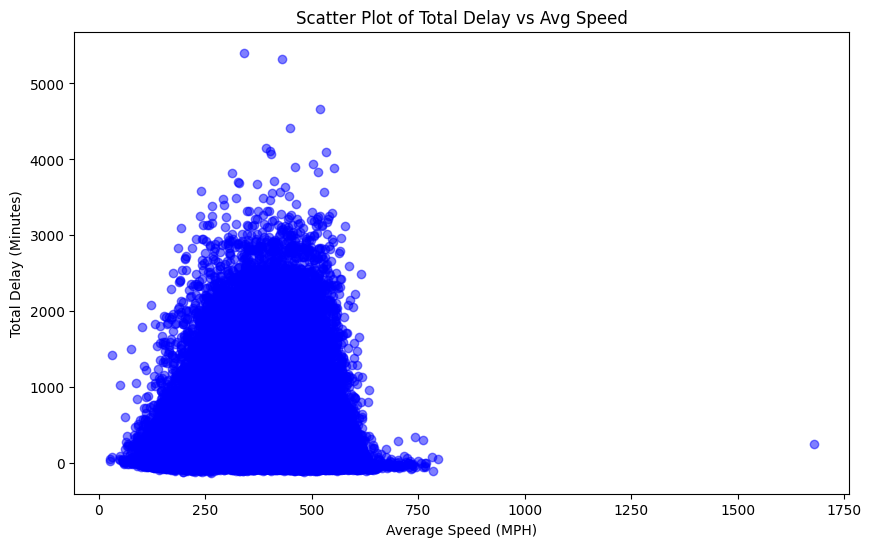

In [92]:
import matplotlib.pyplot as plt
import pandas as pd


df_scatter = df_cleaned.select("TOTAL_DELAY", "AVG_SPEED").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(df_scatter['AVG_SPEED'], df_scatter['TOTAL_DELAY'], alpha=0.5, color='b')
plt.title('Scatter Plot of Total Delay vs Avg Speed')
plt.xlabel('Average Speed (MPH)')
plt.ylabel('Total Delay (Minutes)')
plt.show()


In [93]:
df_cleaned.columns

['FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'ARR_TIME',
 'ARR_DELAY',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'FL_DAY',
 'FL_MONTH',
 'FL_WEEKDAY',
 'DEP_HOUR',
 'DEP_MINUTE',
 'ARR_HOUR',
 'ARR_MINUTE',
 'TOTAL_DELAY',
 'AVG_SPEED']

In [94]:
from pyspark.sql.functions import when
 
df_cleaned = df_cleaned.withColumn(
    "FLIGHT_STATUS", 
    when(df_cleaned["TOTAL_DELAY"] > 0, "Delayed").otherwise("On-time")
)
 
df_cleaned.select("TOTAL_DELAY", "FLIGHT_STATUS").show(5)


+-----------+-------------+
|TOTAL_DELAY|FLIGHT_STATUS|
+-----------+-------------+
|      181.0|      Delayed|
|      335.0|      Delayed|
|       52.0|      Delayed|
|       72.0|      Delayed|
|      194.0|      Delayed|
+-----------+-------------+
only showing top 5 rows



C:\Users\msash\AppData\Local\Temp\ipykernel_33364\2309589460.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FLIGHT_STATUS', y='TOTAL_DELAY', data=df_box_pd, palette='Set2')


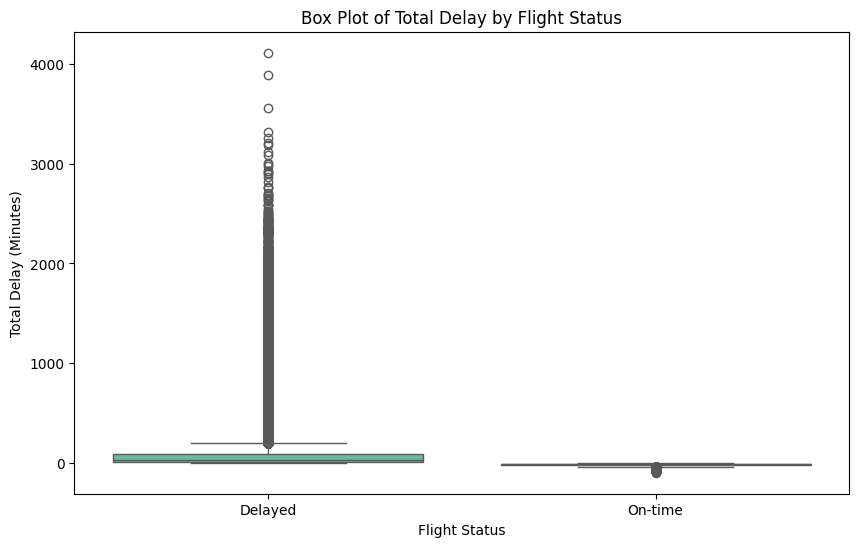

In [95]:
import seaborn as sns
df_box = df_cleaned.select("FLIGHT_STATUS", "TOTAL_DELAY")

df_box_pd = df_box.sample(False, 0.1, seed=0).toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='FLIGHT_STATUS', y='TOTAL_DELAY', data=df_box_pd, palette='Set2')
plt.title('Box Plot of Total Delay by Flight Status')
plt.xlabel('Flight Status')
plt.ylabel('Total Delay (Minutes)')
plt.show()

Algorithms/Visualizations [50 marks]:
1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. Support Vector Regressor (SVR)
5. Gradient Boosting Regressor (GBR)
6. Isotonic Regression





In [96]:
print(df_encoded.columns)

['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_DAY', 'FL_MONTH', 'FL_WEEKDAY', 'DEP_HOUR', 'DEP_MINUTE', 'ARR_HOUR', 'ARR_MINUTE', 'TOTAL_DELAY', 'AVG_SPEED', 'OP_UNIQUE_CARRIER_index', 'ORIGIN_index', 'DEST_index', 'OP_UNIQUE_CARRIER_onehot', 'ORIGIN_onehot', 'DEST_onehot']


In [97]:
from pyspark.ml.feature import VectorAssembler

#feature columns
feature_cols = [
    'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'AIR_TIME', 'DISTANCE',
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY', 'FL_DAY', 'FL_MONTH', 'FL_WEEKDAY',
    'DEP_HOUR', 'DEP_MINUTE', 'ARR_HOUR', 'ARR_MINUTE', 'AVG_SPEED',
    'OP_UNIQUE_CARRIER_onehot', 'ORIGIN_onehot', 'DEST_onehot'
]

# single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_encoded)


df_model = df_assembled.select("features", "TOTAL_DELAY")

In [98]:
from pyspark.sql.functions import col, sum

# Checking null values 
null_counts = df_encoded.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in feature_cols]
)


null_counts.show()


+---------+--------+-------+--------+--------+-------------+-------------+---------+--------------+-------------------+------+--------+----------+--------+----------+--------+----------+---------+------------------------+-------------+-----------+
|DEP_DELAY|TAXI_OUT|TAXI_IN|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|FL_DAY|FL_MONTH|FL_WEEKDAY|DEP_HOUR|DEP_MINUTE|ARR_HOUR|ARR_MINUTE|AVG_SPEED|OP_UNIQUE_CARRIER_onehot|ORIGIN_onehot|DEST_onehot|
+---------+--------+-------+--------+--------+-------------+-------------+---------+--------------+-------------------+------+--------+----------+--------+----------+--------+----------+---------+------------------------+-------------+-----------+
|        0|       0|      0|       0|       0|      5878979|      5878979|  5878979|       5878979|            5878979|     0|       0|         0|       0|         0|       0|         0|        0|                       0|            0|          0|
+-------

In [99]:
from pyspark.ml.feature import Imputer


columns_with_nulls = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
                      'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

#applying mean iputer
imputer = Imputer(inputCols=columns_with_nulls, outputCols=columns_with_nulls).setStrategy("mean")

df_imputed = imputer.fit(df_encoded).transform(df_encoded)


In [100]:
# Rechecking
null_counts_after_imputation = df_imputed.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in feature_cols]
)


null_counts_after_imputation.show()


+---------+--------+-------+--------+--------+-------------+-------------+---------+--------------+-------------------+------+--------+----------+--------+----------+--------+----------+---------+------------------------+-------------+-----------+
|DEP_DELAY|TAXI_OUT|TAXI_IN|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|FL_DAY|FL_MONTH|FL_WEEKDAY|DEP_HOUR|DEP_MINUTE|ARR_HOUR|ARR_MINUTE|AVG_SPEED|OP_UNIQUE_CARRIER_onehot|ORIGIN_onehot|DEST_onehot|
+---------+--------+-------+--------+--------+-------------+-------------+---------+--------------+-------------------+------+--------+----------+--------+----------+--------+----------+---------+------------------------+-------------+-----------+
|        0|       0|      0|       0|       0|            0|            0|        0|             0|                  0|     0|       0|         0|       0|         0|       0|         0|        0|                       0|            0|          0|
+-------

In [101]:
print(df_assembled.columns)

df_assembled.select("features").show(5)


['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_DAY', 'FL_MONTH', 'FL_WEEKDAY', 'DEP_HOUR', 'DEP_MINUTE', 'ARR_HOUR', 'ARR_MINUTE', 'TOTAL_DELAY', 'AVG_SPEED', 'OP_UNIQUE_CARRIER_index', 'ORIGIN_index', 'DEST_index', 'OP_UNIQUE_CARRIER_onehot', 'ORIGIN_onehot', 'DEST_onehot', 'features']
+--------------------+
|            features|
+--------------------+
|(752,[0,1,2,3,4,9...|
|(752,[0,1,2,3,4,5...|
|(752,[0,1,2,3,4,7...|
|(752,[0,1,2,3,4,5...|
|(752,[0,1,2,3,4,5...|
+--------------------+
only showing top 5 rows



In [102]:
from pyspark.ml.feature import VectorAssembler

#features
feature_columns = [
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN", "AIR_TIME", "DISTANCE",
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY", "FL_DAY", "FL_MONTH", "FL_WEEKDAY",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE", "AVG_SPEED"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df_assembled = assembler.transform(df_imputed)

df_model = df_assembled.select("features", "TOTAL_DELAY")

# Splittrain and test sets
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)


In [114]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

#Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="TOTAL_DELAY")

# Train
lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="TOTAL_DELAY", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

# Evaluate R2
evaluator.setMetricName("r2")
lr_r2 = evaluator.evaluate(lr_predictions)

#evaluation metrics
print(f"Linear Regression - RMSE on Test Data: {lr_rmse}")
print(f"Linear Regression - R2 on Test Data: {lr_r2}")


Linear Regression - RMSE on Test Data: 9.145364900115178
Linear Regression - R2 on Test Data: 0.9913908583182436


In [115]:
#DecisionTreeRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol="features", labelCol="TOTAL_DELAY")


dt_model = dt.fit(train_data)

#  predictions
dt_predictions = dt_model.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol="TOTAL_DELAY", predictionCol="prediction", metricName="rmse")
dt_rmse = evaluator.evaluate(dt_predictions)
dt_r2 = evaluator.setMetricName("r2").evaluate(dt_predictions)

# evaluation metrics
print(f"Decision Tree Regressor - RMSE on Test Data: {dt_rmse}")
print(f"Decision Tree Regressor - R2 on Test Data: {dt_r2}")


Decision Tree Regressor - RMSE on Test Data: 51.60060512904213
Decision Tree Regressor - R2 on Test Data: 0.7259262970455126


In [116]:
#RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


rf = RandomForestRegressor(featuresCol="features", labelCol="TOTAL_DELAY", numTrees=50)

# Train
rf_model = rf.fit(train_data)

#predictions
rf_predictions = rf_model.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol="TOTAL_DELAY", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = evaluator.setMetricName("r2").evaluate(rf_predictions)

#evaluation metrics
print(f"Random Forest Regressor - RMSE on Test Data: {rf_rmse}")
print(f"Random Forest Regressor - R2 on Test Data: {rf_r2}")


Random Forest Regressor - RMSE on Test Data: 52.34710313683827
Random Forest Regressor - R2 on Test Data: 0.7179389721553828


In [117]:
# svr_model
from pyspark.ml.regression import LinearRegression

#regularization parameters SVR
svr = LinearRegression(
    featuresCol="features", 
    labelCol="TOTAL_DELAY", 
    regParam=0.1, 
    elasticNetParam=0.5 
)

# Train 
svr_model = svr.fit(train_data)

# predictions 
svr_predictions = svr_model.transform(test_data)

# Evaluate 
evaluator = RegressionEvaluator(labelCol="TOTAL_DELAY", predictionCol="prediction", metricName="rmse")
svr_rmse = evaluator.evaluate(svr_predictions)
svr_r2 = evaluator.setMetricName("r2").evaluate(svr_predictions)

#evaluation metrics
print(f"Support Vector Regressor - RMSE on Test Data: {svr_rmse}")
print(f"Support Vector Regressor - R2 on Test Data: {svr_r2}")


Support Vector Regressor - RMSE on Test Data: 9.182350239909843
Support Vector Regressor - R2 on Test Data: 0.991321083981432


In [118]:
#Gradient Boosting Regressor
from pyspark.ml.regression import GBTRegressor


gbr = GBTRegressor(featuresCol="features", labelCol="TOTAL_DELAY", maxIter=100, stepSize=0.1, maxDepth=5)

# Train
gbr_model = gbr.fit(train_data)


gbr_predictions = gbr_model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="TOTAL_DELAY", predictionCol="prediction", metricName="rmse")
gbr_rmse = evaluator.evaluate(gbr_predictions)
gbr_r2 = evaluator.setMetricName("r2").evaluate(gbr_predictions)

#evaluation metrics
print(f"Gradient Boosting Regressor - RMSE on Test Data: {gbr_rmse}")
print(f"Gradient Boosting Regressor - R2 on Test Data: {gbr_r2}")


Gradient Boosting Regressor - RMSE on Test Data: 49.72662633518347
Gradient Boosting Regressor - R2 on Test Data: 0.7454718799504478


In [119]:
# Isotonic Regression
from pyspark.ml.regression import IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator


isotonic_regressor = IsotonicRegression(featuresCol="features", labelCol="TOTAL_DELAY")

# Train
isotonic_model = isotonic_regressor.fit(train_data)

# Predictions
isotonic_predictions = isotonic_model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="TOTAL_DELAY", predictionCol="prediction", metricName="rmse")
isotonic_rmse = evaluator.evaluate(isotonic_predictions)
isotonic_r2 = evaluator.setMetricName("r2").evaluate(isotonic_predictions)

# Evaluation metrics
print(f"Isotonic Regression - RMSE on Test Data: {isotonic_rmse}")
print(f"Isotonic Regression - R2 on Test Data: {isotonic_r2}")


Isotonic Regression - RMSE on Test Data: 13.644708803169166
Isotonic Regression - R2 on Test Data: 0.9808359929733631


Comparing and visualizing models

In [109]:

model_results = [
    ("Linear Regression", lr_rmse, lr_r2),
    ("Decision Tree", dt_rmse, dt_r2),
    ("Random Forest", rf_rmse, rf_r2),
    ("Support Vector Regressor", svr_rmse, svr_r2),
    ("Gradient Boosting", gbr_rmse, gbr_r2),
    ("Isotonic Regression", isotonic_rmse, isotonic_r2)
]


results_df = spark.createDataFrame(model_results, ["Model", "RMSE", "R2"])

results_df.show()


+--------------------+------------------+------------------+
|               Model|              RMSE|                R2|
+--------------------+------------------+------------------+
|   Linear Regression|  9.14536490011518|0.9913908583182436|
|       Decision Tree| 51.60060512904213|0.7259262970455127|
|       Random Forest| 52.34710313683827|0.7179389721553828|
|Support Vector Re...| 9.182350239909836|0.9913210839814321|
|   Gradient Boosting| 49.72662633518347|0.7454718799504478|
| Isotonic Regression|13.644708803169166|0.9808359929733631|
+--------------------+------------------+------------------+



In [110]:
import matplotlib.pyplot as plt


results_local = results_df.collect()


model_names = [row['Model'] for row in results_local]
rmse_values = [row['RMSE'] for row in results_local]
r2_values = [row['R2'] for row in results_local]


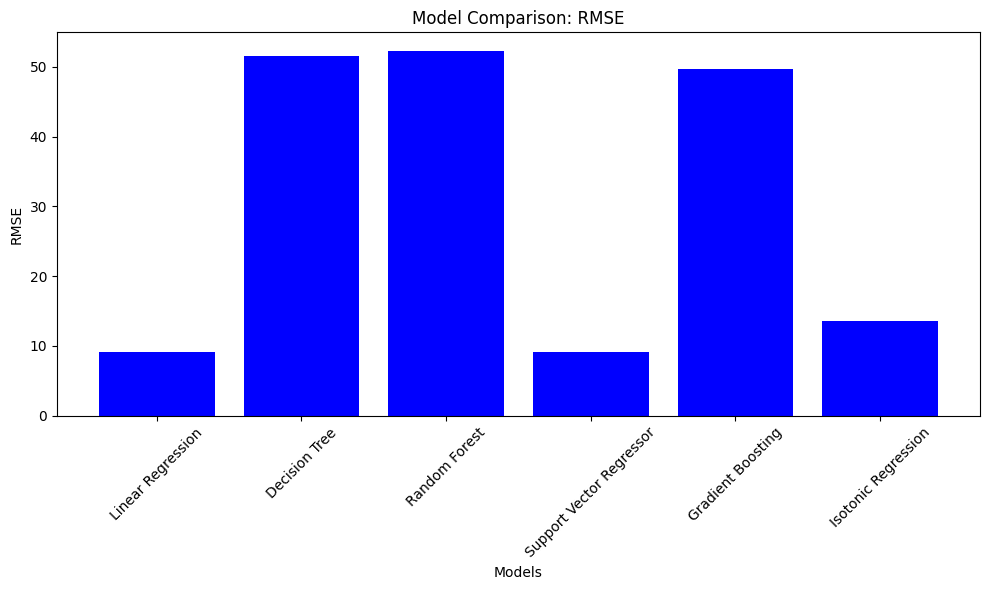

In [111]:
#plot for RMSE
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(model_names, rmse_values, color='blue')

ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison: RMSE')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



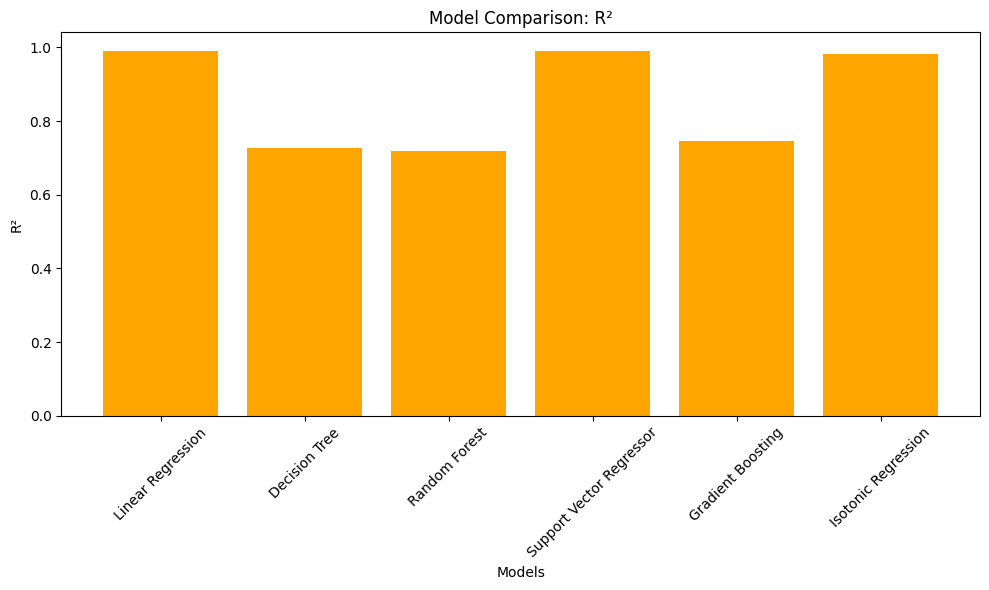

In [112]:
#plot for R²
fig, ax = plt.subplots(figsize=(10, 6))

 
ax.bar(model_names, r2_values, color='orange')
 
ax.set_xlabel('Models')
ax.set_ylabel('R²')
ax.set_title('Model Comparison: R²')
 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [113]:
print("Spark Web UI:", sc.uiWebUrl)

Spark Web UI: http://Sashank-Laptop:4081
